In [52]:
import spacy
from spacy.tokens import Doc, Token, Span
from spacy.matcher import PhraseMatcher, Matcher

import random

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Training and updating models

## Using `Matcher` to get training data

In [41]:
nlp = spacy.load('en_core_web_sm')

In [42]:
# Initialize Matcher
matcher = Matcher(nlp.vocab)

In [43]:
# Create patterns to match iPhone X and other iPhone models
pattern1 = [{'LOWER': 'iphone'}, {'LOWER': 'x'}]
# pattern2 = [{'LOWER': 'iphone'}, {'IS_DIGIT': True, 'OP': '?'}]

# Add patterns to the matcher
matcher.add('GADGET', None, pattern1)

In [44]:
# Define phrases
phone_pharses = ['I just bought a new iPhone X!', 'Had iPhone X for a month, but it broke', 
                 'iPhone 6 was my favorite!', 'Need a new phone, any tips?', 'Best iPhone X deals in Boston!']

In [45]:
for doc in nlp.pipe(phone_pharses):
    # Find the matches in the doc
    matches = matcher(doc)
    
    # Print results
    entities = [(start, end, 'GADGET') for match_id, start, end in matches]
    print(doc.text, entities) 

I just bought a new iPhone X! [(5, 7, 'GADGET')]
Had iPhone X for a month, but it broke [(1, 3, 'GADGET')]
iPhone 6 was my favorite! []
Need a new phone, any tips? []
Best iPhone X deals in Boston! [(1, 3, 'GADGET')]


In [46]:
# Build a training set
TRAINING_DATA = []

# Create a Doc object for each text in TEXTS
for doc in nlp.pipe(phone_pharses):
    # Match on the doc and create a list of matched spans
    spans = [doc[start:end] for match_id, start, end in matcher(doc)]
    # Get (start character, end character, label) tuples of matches
    entities = [(span.start_char, span.end_char, 'GADGET') for span in spans]
    
    # Format the matches as a (doc.text, entities) tuple
    training_example = (doc.text, {'entities': entities})
    # Append the example to the training data
    TRAINING_DATA.append(training_example)
   

In [47]:
# Print out the training data
print(*TRAINING_DATA, sep='\n') 

('I just bought a new iPhone X!', {'entities': [(20, 28, 'GADGET')]})
('Had iPhone X for a month, but it broke', {'entities': [(4, 12, 'GADGET')]})
('iPhone 6 was my favorite!', {'entities': []})
('Need a new phone, any tips?', {'entities': []})
('Best iPhone X deals in Boston!', {'entities': [(5, 13, 'GADGET')]})


## Train a model from scratch

In [63]:
# Create a blank 'en' model
nlp = spacy.blank('en')

# Create a new entity recognizer and add it to the pipeline
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

# Add the label 'GADGET' to the entity recognizer
ner.add_label('GADGET')

In [64]:
# Start the training
nlp.begin_training()

In [65]:
# Loop for 10 iterations
loss = []
for i in range(10):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    losses = {}
    
    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size = 3):
        texts = [text for text, entities in batch]
        annotations = [entities for text, entities in batch]
        
        # Update the model
        nlp.update(texts, annotations, losses = losses)
        
    loss.append(losses)

In [72]:
# Visualize the loss
loss_ = [x['ner'] for x in loss]

[]

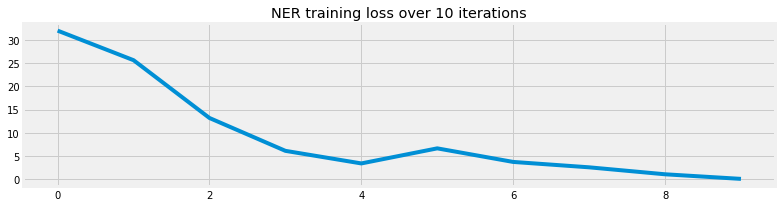

In [75]:
plt.figure(figsize = (12, 3))
plt.plot(loss_)
plt.title('NER training loss over 10 iterations')
plt.plot()